In [1]:
%env MKL_THREADING_LAYER=GNU
%env THEANO_FLAGS=device=cpu,floatX=float64
# optimizer=fast_run,NanGuardMode.action=warn
# use device=cuda for gpu support

env: MKL_THREADING_LAYER=GNU
env: THEANO_FLAGS=device=cpu,floatX=float64


In [2]:
import sys
from __future__ import division
add = __builtin__.sum

In [3]:
from theano import clone, function, pp, shared
from theano.tensor import (concatenate, config, cosh, dot, erfinv, eq, grad, min,
                           scalar, scalars, shape_padright, sqrt, sum, switch,
                           tensor3, tensor5, TensorType, tile, vector)
from theano.printing import debugprint, pydotprint
#from theano.tensor.shared_randomstreams import RandomStreams
# used later
from theano.tensor import roll, stack

In [4]:
from numpy import (array, arange, asarray, exp, full, Inf, linspace,
                   mean, meshgrid, pi, roll)
# used later
#from numpy import roll, stack

In [5]:
from sympy import (Abs, Eq, exp as Exp, I, init_printing, integrate,
                   oo, Matrix, pi as Pi, solve, symbols, Symbol)
#from sympy.printing.theanocode
# added erfinv
from theanocode import theano_code, theano_function
#from pymatrix import matrix, Matrix

In [6]:
init_printing()

In [7]:
from IPython.display import display, HTML, SVG

In [8]:
%matplotlib inline
#import matplotlib
from matplotlib.pyplot import (axes, close, contour, contourf, figure, legend,
                               plot, scatter, show, title, xlabel, ylabel,
                               xlim,ylim)
from matplotlib.cm import * #coolwarm, Spectral
from mpl_toolkits.mplot3d import axes3d
from matplotlib import animation

In [9]:
from sdict import select
# E.g. select({3:3.2,2:2.2})[[2,3]] or
S=select({3:3.2,2:2.2})
S[array([2,3,2,2])]

array([ 2.2,  3.2,  2.2,  2.2])

In [10]:
from smatrix import *
# E.g.
print matrix([[1,2],[3,4]]).inverse()

-2   1

 1  -1


In [11]:
# function of specified variables fun(y,...) from expression f
# where: fun(x,y)(f)(x,y) = f
def fun(*y):
    try: # theano?
        return lambda f: lambda *x: clone(f, dict([[y[i],x[i]] for i in range(len(y))]),strict=False)
    except:
        return lambda f: lambda *x: f.subs( dict([[y[i],x[i]] for i in range(len(y))]))

The multidimensional symbolic array $C$ represents a "uniformizing" mapping of worlds into configuration space, i.e. the position of each particle in each world.

In [12]:
dim = range(2) # dimension
C = TensorType(config.floatX, (False,)*(1+len(dim)))('C') # shape: d * N**d

#### Boundary Conditions

We introduce fictitious worlds, two worlds deep, at the edges of the array to represent boundary conditions. Boundry worlds can be removed or set to zero.

In [13]:
B=2
def boundary0(r):
    for i in range(r.ndim):
        rs = list(r.shape); rs[i]=1
        s = [1]*r.ndim; s[i]=B
        before1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        s = [1]*r.ndim; s[i]=B
        after1 = tile(array([0]*B,config.floatX).reshape(*s),rs)
        r = concatenate([before1,r,after1], axis=i)
    return r

In [14]:
def boundary(s): return stack([boundary0(r) for r in s])

In [15]:
def debound(r): return r[tuple([slice(B,-B)]*(r.ndim))]

In [16]:
# uniform grid between 0 and 1 of dimension d and size N
def grid(d,N):
    return array(meshgrid(*[arange(0.0+0.5/N,1.0,1.0/N,config.floatX)]*d,
                              indexing='ij'))

In [17]:
# E.g.
grid(2,2)

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

In [18]:
boundary(grid(2,2)).eval()

array([[[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.25,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.75,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.25,  0.75,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]])

In [19]:
array(list(map(debound,boundary(grid(2,2)).eval())))

array([[[ 0.25,  0.25],
        [ 0.75,  0.75]],

       [[ 0.25,  0.75],
        [ 0.25,  0.75]]])

### Difference operator ###

In [20]:
# In the following use numpy's roll and stack. Later we will use theano for these operations.
from numpy import roll, stack

In [21]:
N=9

Symbolic grid.

In [22]:
var=['x','y']

In [23]:
xb=array(meshgrid(*[symbols(['%s_{%s}'%(var[j].replace(' ',''),str(Symbol("i")+(i-N//2)).replace(' ','')) for i in range(N)]) for j in dim],indexing='ij'))
xb.shape

In [24]:
Matrix(xb[0].tolist())

⎡x_{i-4}  x_{i-4}  x_{i-4}  x_{i-4}  x_{i-4}  x_{i-4}  x_{i-4}  x_{i-4}  x_{i-
⎢                                                                             
⎢x_{i-3}  x_{i-3}  x_{i-3}  x_{i-3}  x_{i-3}  x_{i-3}  x_{i-3}  x_{i-3}  x_{i-
⎢                                                                             
⎢x_{i-2}  x_{i-2}  x_{i-2}  x_{i-2}  x_{i-2}  x_{i-2}  x_{i-2}  x_{i-2}  x_{i-
⎢                                                                             
⎢x_{i-1}  x_{i-1}  x_{i-1}  x_{i-1}  x_{i-1}  x_{i-1}  x_{i-1}  x_{i-1}  x_{i-
⎢                                                                             
⎢ x_{i}    x_{i}    x_{i}    x_{i}    x_{i}    x_{i}    x_{i}    x_{i}    x_{i
⎢                                                                             
⎢x_{i+1}  x_{i+1}  x_{i+1}  x_{i+1}  x_{i+1}  x_{i+1}  x_{i+1}  x_{i+1}  x_{i+
⎢                                                                             
⎢x_{i+2}  x_{i+2}  x_{i+2}  x_{i+2}  x_{i+2}  x_{i+2

In [25]:
Matrix(xb[1].tolist())

⎡y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1}  y_{i+2}  y_{i+3}  y_{i+4}
⎢                                                                             
⎢y_{i-4}  y_{i-3}  y_{i-2}  y_{i-1}  y_{i}  y_{i+1} 

In [26]:
xb[0,:,N//2].tolist()

In [27]:
xb[1,N//2,:].tolist()

The index of the $i^{th}$ world with boundry worlds removed:

In [28]:
x=array(map(debound,xb))

In [29]:
ith = N//2-B
x_i=x[0][ith,ith]
y_i=x[1][ith,ith]
(x_i,y_i)

Forward and backward differences

In [30]:
def d(dir,x,i):
    if dir<0:
        return roll(x, dir, axis = i) - x
    else:
        return x - roll(x, dir, axis = i)

In [31]:
debound(d(+1,xb[0],0)).tolist()

In [32]:
debound(d(-1,xb[0],0)).tolist()

Jacobian

In [33]:
def J(C): return matrix([[d(-1,C[j],i) for i in dim] for j in dim])

In [34]:
def K(C): return 1/J(C)

#### Quantum Potential (Schiff&Poirier eq. 20)####

In [35]:
hbar=Symbol('hbar') # Planck's constant

In [36]:
mu=array(symbols(['mu%s'%i for i in dim])) # mass
list(mu)

In [37]:
def Q(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           -hbar**2/(4*mu[j])*(K_C[k,j]*d(-1,d(+1,K_C[l,j], k), l) + d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)/2)
                 for k in dim]) for j in dim]) for l in dim]))

The quantum potential at the $i^{th}$ world:

In [38]:
Qs=Q(hbar,mu,xb)
Qs.shape

The $i^{th}$ entry in this array is generic, i.e. independent of the worlds at the boundary.

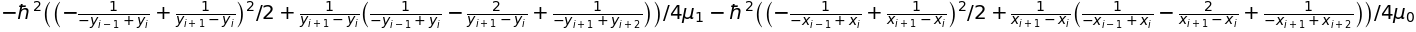

In [39]:
Qs[ith,ith]

#### Quantum Force ####

In general the force is a vector.
Provided the number of worlds is large enough the trace of Q contains sufficient information to compute gradients.

In [40]:
QU=add([Qs[i,i] for i in range(N-2*B)]) # trace

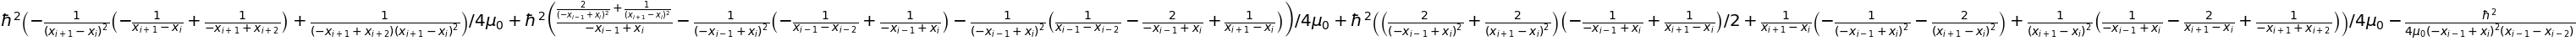

In [41]:
R0 = -QU.diff(x_i); R0

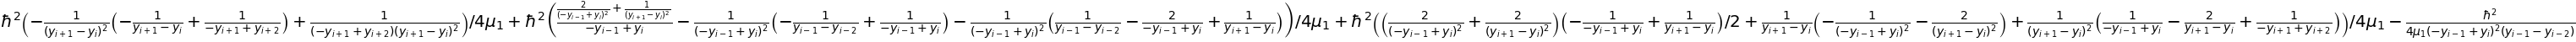

In [42]:
R1 = -QU.diff(y_i); R1

These are the same expressions in different variables! If we have computed the gradients properly this means that the quantum force is "separable".  The forces on each axis (orthogonal directions) are independent of each other. Therefore the generalization to higher dimensions/multiple particles is essentially trivial.

 Schiff & Poirier eq 18

In [43]:
def R(hbar,mu,C):
    K_C=K(C)
    return stack([debound(add([add([add([add([
      hbar**2/(4*mu[j])*d(+1,K_C[k, i]*K_C[p, j]*d(-1,d(+1,K_C[l, j], k), l), p)
        for p in dim]) for k in dim]) for j in dim]) for l in dim]))
            for i in dim])

In [44]:
Rs=R(hbar,mu,xb)
Rs.shape

Again, the $i^{th}$ entry in these arrays are generic, i.e. independent of the boundary worlds.

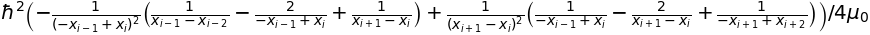

In [45]:
Rs[0,ith,ith]

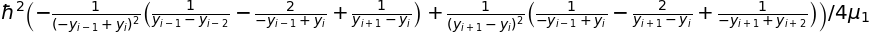

In [46]:
Rs[1,ith,ith]

As expected, the discretized Schiff and Poirier expression for the quantum force is the gradient of the discretized quantum potential.

In [47]:
print Rs[0,ith,ith].expand()==R0.expand()
print Rs[1,ith,ith].expand()==R1.expand()

True
True


It is also interesting to note that the gradient of a simpler potential, which differs from the $2^{nd}$ order term in Schiff&Poirier eq. 20 by only the sign, yields the same expression for the quantum force. This turns out to be the same quantum potential as introduced by Hall&Deckart.

In [48]:
def Q2(hbar,mu,C):
    K_C = K(C)
    return debound(add([add([add([
           hbar**2/(8*mu[j])*d(+1,K_C[l,j], l)*d(+1,K_C[k,j], k)
                 for k in dim]) for j in dim]) for l in dim]))

In [49]:
Qs2=Q2(hbar,mu,xb)

The discretized version of this expression is identical to that introduced by Hall & Deckart.

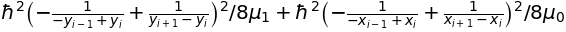

In [50]:
Qs2[ith,ith]

Gradient of the trace.

In [51]:
Q2R0 = -add([Qs2[i,i] for i in range(N-2*B)]).diff(x_i)
Q2R1 = -add([Qs2[i,i] for i in range(N-2*B)]).diff(y_i)

In [52]:
((Rs[0,ith,ith] - Q2R0).simplify()==0 and
 (Rs[1,ith,ith] - Q2R1).simplify()==0)

True

### Numeric computation ###

These expressions can be converted directly to Theano functions for efficient execution on gpu and multicore processors.

In [53]:
from theano.tensor import roll, stack

In [54]:
hbar_s = theano_code(hbar)
mu_v = vector('mu')

Without sympy simplification Theano would produce the following expressions (disabled below since they are not needed in this worksheet):

$3^{rd}$ order potential

In [55]:
#Q_=function([hbar_s,mu_v,C],Q(hbar_s,mu_v,C))
#pp(Q_.maker.fgraph.outputs[0])

$2^{nd}$ order potential

In [56]:
#Q2_=function([hbar_s,mu_v,C],Q2(hbar_s,mu_v,C))
#pp(Q2_.maker.fgraph.outputs[0])

Quantum force

In [57]:
#R_=function([hbar_s,mu_v,C],R(hbar_s,mu_v,C))
#pp(R_.maker.fgraph.outputs[0])

Even after Theano graph optimization the functions obtained from the sympy simplified expressions above are shorter than those produced directly by Theano. To conversion the sympy expressions to Theano, we just need to replace symbols with appropriate vector operators:

In [58]:
ro2=dict(
     # replace mu scalars with vector
     [[theano_code(mu[0]),mu_v[0]], [theano_code(mu[1]),mu_v[1]]]+
     # replace subscripted symbols with vector operators
     [[theano_code(x[j,ith-i,ith-i]),roll(C[j],i,axis=j)] for j in dim for i in range(-2,3)])

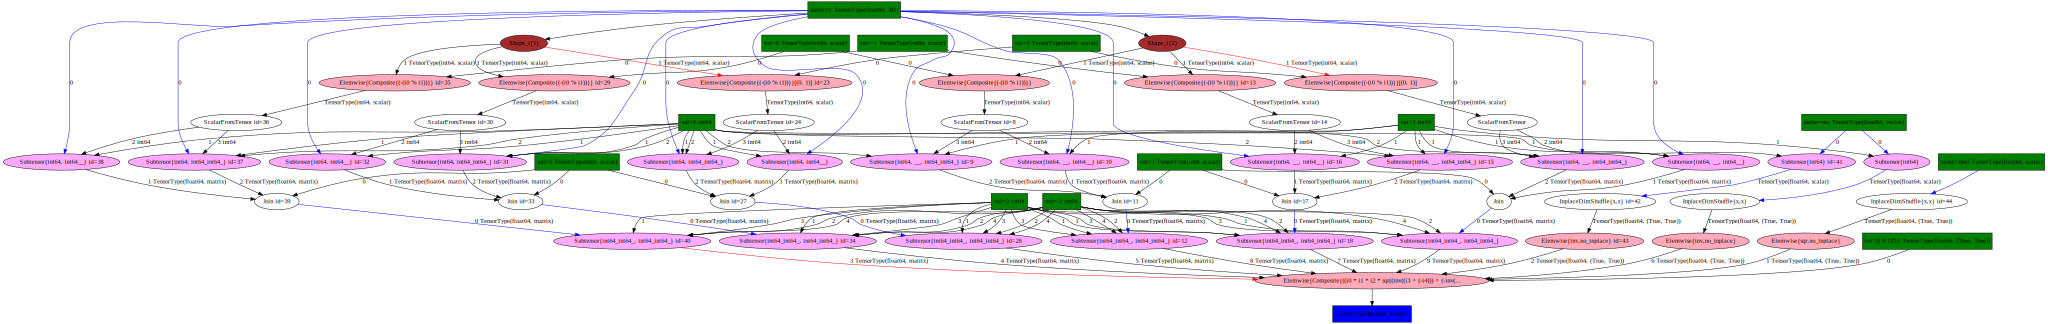

In [59]:
Q2b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Qs2[ith,ith]),ro2,strict=False)))
Q2b_=function([hbar_s,mu_v,C],Q2b(hbar_s,mu_v,C))
SVG(pydotprint(Q2b_.maker.fgraph.outputs[0], return_image=True, format='svg'))

In [60]:
R0b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[0,ith,ith]),ro2,strict=False)))
R1b=fun(hbar_s,mu_v,C)(debound(clone(theano_code(Rs[1,ith,ith]),ro2,strict=False)))

In [61]:
def Rb(hbar_s,mu_v,C): return stack([R0b(hbar_s,mu_v,C),R1b(hbar_s,mu_v,C)])
Rb_=function([hbar_s,mu_v,C],Rb(hbar_s,mu_v,C))

#### Density ####

In [62]:
D_ = function([C],debound(1/J(C).determinant()))

### Simulation ###

Using the expressions derived above we can generate efficient numerical functions which we use later in determining the motion of a particle in many worlds simultaneously.

We use the discrete difference approximation to Poirier's equations above for a numerical simulation of quantum motion in a small number of ``parallel'' worlds.

#### Classical Potential ####

In [63]:
x1,y1=scalars('x1','y1')

In [64]:
# Modified Coulomb interaction.
# The constant in the square root makes this continuously differentiable.
V = fun(x1,y1) (-1.0/sqrt((x1-y1)**2+0.000001))

In [65]:
# clone to compile vectorized numeric function
V_ = function([C],V(C[0],C[1]))

In [66]:
testgrid=0.1*(grid(2,500)-0.5)
testgrid.shape

In [67]:
V_(testgrid).shape

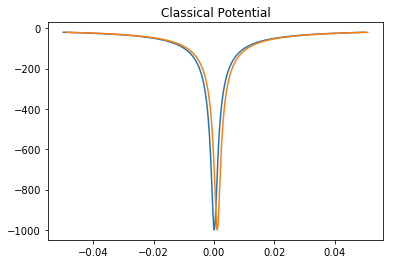

In [68]:
plot(testgrid[0][:,250],V_(testgrid)[:,250])
plot(testgrid[1][250,:]+0.001,V_(testgrid)[250,:])
title('Classical Potential')
show()

#### Classical Force ####

In [69]:
# symbolic gradient
Fx1 = fun(x1,y1) (-grad(V(x1,y1),x1))
Fy1 = fun(x1,y1) (-grad(V(x1,y1),y1))

In [70]:
F_ = function([C],stack([Fx1(C[0],C[1]),Fy1(C[0],C[1])]))

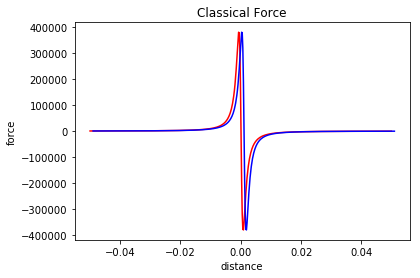

In [71]:
plot(testgrid[0][:,250],F_(testgrid)[0][:,250],
     color='red')
plot(testgrid[1][250,:]+0.001,F_(testgrid)[1][250,:],
     color='blue')
title('Classical Force')
xlabel('distance'); ylabel('force')
show()

### Initial Data ###

We introduce two widely separated fictitious worlds (not subject to dynamics) to the left and right to approximate open boundary conditions.

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ "parallel" worlds.

In [72]:
N = 10

#### Spatial Distribution

For example consider the spatial distribution of a Gaussian ensemble of one particle in  $N$ ``parallel'' worlds. Everything is in atomic units below, so $\hbar=1$.

In [163]:
bx1=2*(arange(0.0+0.5/(N+2*B),1.0,1.0/(N+2*B),config.floatX)-0.5)
bxy=array(meshgrid(bx1,bx1,indexing='ij'))
bxy.shape

In [164]:
xy=array(list(map(debound,bxy))); xy.shape

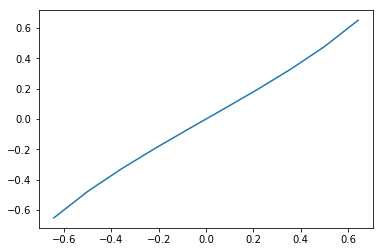

In [165]:
plot(xy[0][:,0],erfinv(xy[0][:,0]).eval()); show()

In [167]:
g1=erfinv(2*(arange(0.0+0.5/(N+2*B),1.0,1.0/(N+2*B),config.floatX)-0.5)).eval()
g1[0] -= 1e12;       g1[1] -= 1e6;       g1[-2] += 1e6;       g1[-1] += 1e12
b0=array(meshgrid(50*g1-50,g1,indexing='ij'))
b0.shape

In [216]:
crosses=fun(C)(min([debound(d(-1,C[j],j)) for j in dim])<0)

In [217]:
crosses(b0).eval()

array(False, dtype=bool)

In [218]:
b0[0][:3,5],b0[0][-3:,5]

(array([ -5.00000000e+13,  -5.00000939e+07,  -8.25560085e+01]),
 array([ -1.74439915e+01,   4.99999939e+07,   5.00000000e+13]))

In [219]:
b0[0][5,:3],b0[0][5,-3:]

(array([-59.61240977, -59.61240977, -59.61240977]),
 array([-59.61240977, -59.61240977, -59.61240977]))

In [220]:
b0[1][:3,5],b0[1][-3:,5]

(array([-0.1922482, -0.1922482, -0.1922482]),
 array([-0.1922482, -0.1922482, -0.1922482]))

In [221]:
b0[1][5,:3],b0[1][5,-3:]

(array([ -1.00000000e+12,  -1.00000088e+06,  -6.51120171e-01]),
 array([  6.51120171e-01,   1.00000088e+06,   1.00000000e+12]))

In [222]:
p0 = array(list(map(debound,b0)))
p0.shape

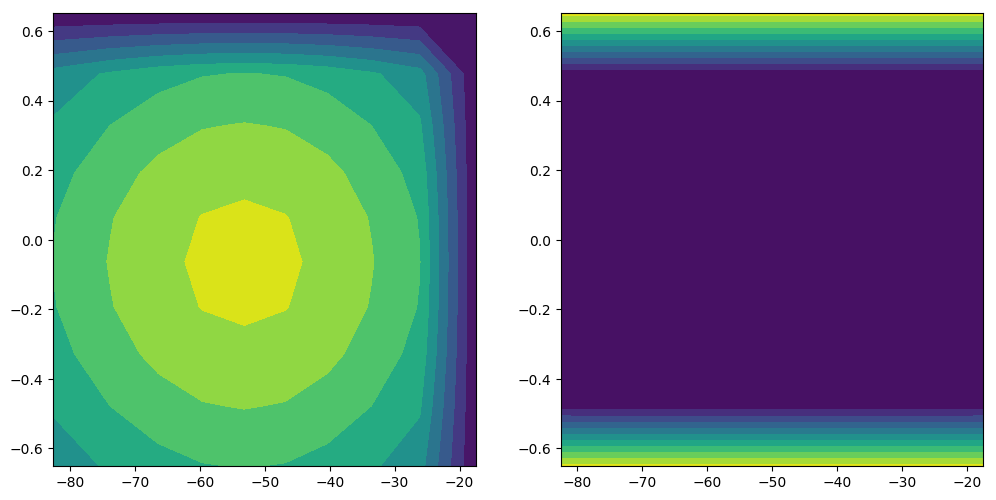

In [175]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
#ax1.set_aspect('equal')
ax1.contourf(p0[0],p0[1],D_(b0),10)
ax2=fig.add_subplot(122)
#ax2.set_aspect('equal')
ax2.contourf(p0[0],p0[1],Q2b_(1,[1,1],b0),10)
show()

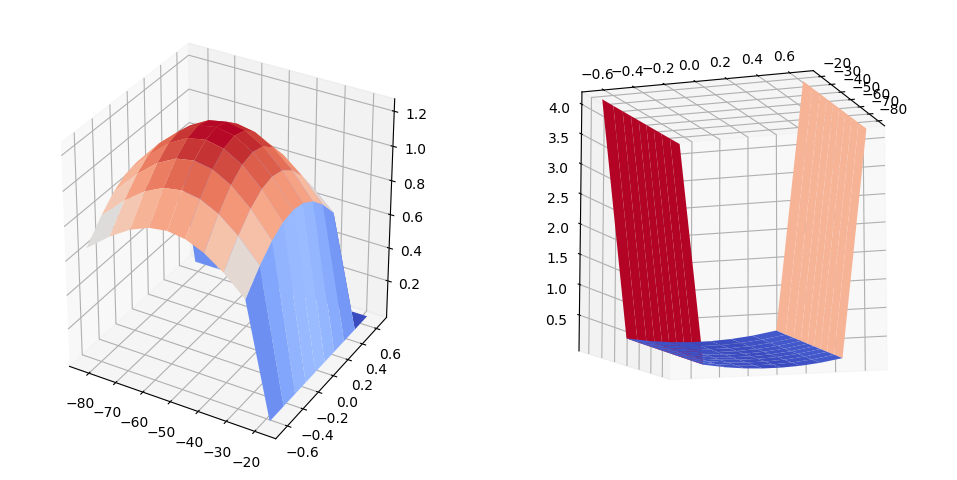

In [176]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], D_(b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(10, 30)
ax2.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
ax2.view_init(-10, 20)
show()

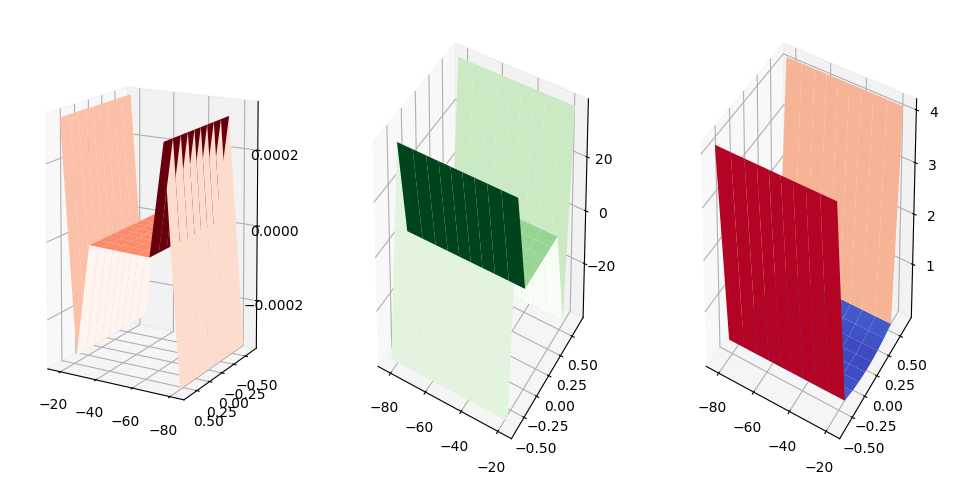

In [177]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
# Plot the surface
ax1.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[0], cmap=Reds, linewidth=0, antialiased=True)
ax1.view_init(10, 120)
ax2.plot_surface(p0[0], p0[1], Rb_(1,[1,1],b0)[1], cmap=Greens, linewidth=0, antialiased=True)
#ax2.view_init(10, 240)
ax3.plot_surface(p0[0], p0[1], Q2b_(1,[1,1],b0), cmap=coolwarm, linewidth=0, antialiased=True)
#ax3.view_init(10, 20)
show()

We will use numeric functions based on the simplified sympy expressions for the quantum potential and force in the following simulation.

#### Distribution of Velocity ####
The electron ensemble approachs the proton ensemble with the same initial velocity in each world.

In [178]:
#v0=full(b0.shape,0.0,config.floatX)
#v0=array(meshgrid(array([1.0 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))
v0=array(meshgrid(array([0.001 for i in range(N+2*B)],config.floatX),array([0.0 for i in range(N+2*B)],config.floatX)))


#### Acceleration ####

In [223]:
def boundary2(s): return stack([boundary0(s[i]) for i in dim])

In [224]:
def debound2(s): return stack([debound(s[i]) for i in dim])

In [225]:
def F(C): return stack([
            Fx1(C[0],C[1]),
            Fy1(C[0],C[1])])

In [226]:
def A(hbar,mu,x):
    return shape_padright(1/mu,2)*boundary2(F(debound2(x)) + Rb(hbar,mu,x))

#### Step Size Controller ####
Continuous integrating step size controller \cite{hairer2005}

In [492]:
def G(a,v):
    alpha = -60.0 # sensitivity
    eps = 1e-12
    g1 = sum(a*v)
    g2 = sum(v**2)
    #print g1.eval(),g2.eval()
    return switch(eq(g2,0),1/eps,-alpha*g1/g2)

#### Integration ####
Integrate using the Störmer–Verlet algorithm with adaptive step size.

In [493]:
mu = array([1.0,1836.0])  # mass
hbar = 1.0 # Planck's constant
rho = shared(asarray(1.0, config.floatX),'rho')
ds = scalar('ds')
dt = ds/rho
t = shared(asarray(0.0, config.floatX),'t')
x = shared(b0,'x')

In [494]:
a0 = A(hbar,mu,x).eval()

In [495]:
a = shared(a0,'a')
v = shared(v0,'v')
x_new = x+v*dt+0.5*a*dt**2
a_new = A(hbar,mu,x_new)
v_new = v+0.5*a*dt+0.5*a_new*dt

In [496]:
VerletStep = function([ds],t, updates=[
    (rho, rho + G(a_new,v_new)*dt ),
    (x, x_new ),
    (v, v_new ),
    (a, a_new ),
    (t, t + dt)
],allow_input_downcast=True)

#### Energy ####

In [497]:
KU1 = 0.5*sum(add([mu[j]*v[j]**2 for j in dim]))  # total kinetic energy
PU1 = sum(debound(V(x[0],x[1])))             # total classical potential
QU1 = sum(Q2b(hbar,mu,x))            # total quantum potential

In [498]:
E_ = function([],[KU1,PU1,QU1])

In [499]:
E_()

[array(9.799999999999978e-05),
 array(-2.477825178787869),
 array(0.08148588600640522)]

In [500]:
crossing=function([],crosses(x))

In [501]:
crossing()

array(False, dtype=bool)

In [506]:
t_start = 0.0; t_end = 1000.0;
t_samples = 200; x_samples = N;

t_sample = t_end/t_samples
x_sample = __builtin__.max(1,int(N)//int(x_samples))
x_start = __builtin__.max(0,int(N-x_samples*x_sample)//int(2))
XS = array(range(B+x_start,B+N-x_start,x_sample))
#ds0 = 0.0001 # N=10 # initial step size
ds0 = 0.25e-02 # N=10 # initial step size
#ds0 = 2.5e-06 # N=20 # initial step size
dsn = 1 # initial step size divider

In [507]:
while True:
    try: # step size
        ds = ds0/dsn
        # initial values
        rho0 = 1.0
        rho.set_value(rho0)
        t.set_value(t_start)
        x.set_value(b0)
        v.set_value(v0)
        a.set_value(a0)
        # recording
        T = [t_start]
        Rho = select({t_start:rho.get_value().item()})
        XX = select({t_start:x.get_value()[:,XS][:,:,XS]})
        XV = select({t_start:v.get_value()[:,XS][:,:,XS]})
        [KK,PP,QQ] = E_()
        E1 = KK+PP+QQ  # total energy
        TK = select({t_start:KK})
        TP = select({t_start:PP})
        TQ = select({t_start:QQ})
        E = select({t_start:E1})
        try:
            t0 = t.get_value().item()
            while t0<t_end:
                t1 = t0 + t_sample
                while t0<t1:
                    rho0 = rho.get_value().item()
                    if rho0 > 10000 or rho0 < 0.01:
                        raise ValueError("Step control failed at %s. rho=%s"%(t0,rho0))
                    t0 = VerletStep(ds).item()
                if crossing(): raise ValueError("crossing at %s",t0)
                # Check total energy conservation
                [KK,PP,QQ] = E_()
                E2 = KK+PP+QQ
                if abs(E1-E2)>0.01:
                    raise ValueError(
                        "Energy conservation bound failed at %s. Delta E:"\
                        "|%s| > 0.01."%(t0,E1-E2))
                print "t =", t0, "t1 =",t1,"rho =", rho0, "delta E =",E1-E2
                sys.stdout.flush()
                E1 = E2
                T += [t0]
                XX[t0] = x.get_value()[:,XS][:,:,XS]
                XV[t0] = v.get_value()[:,XS][:,:,XS]
                Rho[t0] = rho.get_value().item()
                TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
                t0 = t.get_value().item()
        except KeyboardInterrupt:
            print "Interrupted at %s ..."%(t0)
            T += [t0]
            XX[t0] = x.get_value()[:,XS][:,:,XS]
            XV[t0] = v.get_value()[:,XS][:,:,XS]
            Rho[t0] = rho.get_value().item(); TK[t0] = KK; TP[t0] = PP; TQ[t0] = QQ; E[t0] = E1
        tmax = t0
        break
    except ValueError as msg:
        print msg
        tmax = t0
        #break
        dsn = dsn + 1
        print "Trying a shorter initial step size: %s."%(ds0/dsn)
        continue
T=array(T)
print "t =", tmax

t = 5.00002626332 t1 = 5.0 rho = 98.5967156527 delta E = -1.46549439251e-14
t = 10.0000689459 t1 = 10.0000668326 rho = 136.989558894 delta E = -1.64313007645e-13
t = 15.0001203247 t1 = 15.0000981452 rho = 160.589339592 delta E = 1.24344978758e-14
t = 20.0001597592 t1 = 20.0001452329 rho = 177.830785137 delta E = 9.27258270167e-13
t = 25.0001906152 t1 = 25.0001822525 rho = 191.594134163 delta E = -1.99085192776e-12
t = 30.0002280141 t1 = 30.0002114926 rho = 203.223949401 delta E = 2.82529555307e-12
t = 35.0002574653 t1 = 35.0002476968 rho = 213.474568863 delta E = 4.67137439841e-12
t = 40.0002794725 t1 = 40.0002762029 rho = 222.832916321 delta E = -4.28146407216e-12
t = 45.0003072341 t1 = 45.0002974231 rho = 231.659268529 delta E = -3.08642000846e-12
t = 50.0003360016 t1 = 50.0003245009 rho = 240.266822219 delta E = -4.5941028759e-12
t = 55.0003671805 t1 = 55.0003526498 rho = 248.989250927 delta E = -3.11173309342e-12
t = 60.0003895679 t1 = 60.0003832455 rho = 258.280289845 delta E = -4

t = 490.002062164 t1 = 490.00205477 rho = 338.825806017 delta E = -0.000385034926072
t = 495.002080763 t1 = 495.00207397 rho = 330.610517566 delta E = 1.13953291248e-12
t = 500.002103962 t1 = 500.002092862 rho = 325.597598671 delta E = 3.39683836614e-12
t = 505.002117848 t1 = 505.002116247 rho = 330.490497162 delta E = -8.43014547058e-12
t = 510.002136352 t1 = 510.002129951 rho = 325.769335278 delta E = 0.000944218650833
t = 515.00215443 t1 = 515.002148631 rho = 332.233770462 delta E = -2.05848671442e-11
t = 520.002177151 t1 = 520.002166469 rho = 329.131761504 delta E = -7.68835177221e-05
t = 525.002194029 t1 = 525.002189304 rho = 328.825880508 delta E = 0.000868853814975
t = 530.002207622 t1 = 530.002206194 rho = 324.100202262 delta E = -0.000293540617998
t = 535.00222328 t1 = 535.002219964 rho = 322.726785207 delta E = -1.0236256287e-12
t = 540.002239286 t1 = 540.002235674 rho = 327.879103035 delta E = 0.000361692737155
t = 545.002262589 t1 = 545.002251486 rho = 324.050830589 delta E

t = 975.003586758 t1 = 975.003585769 rho = 442.72207174 delta E = -0.00109805409025
t = 980.003599657 t1 = 980.003595793 rho = 447.827426212 delta E = -0.0015141119355
t = 985.003611492 t1 = 985.003608589 rho = 444.556096954 delta E = -0.00124146989791
t = 990.003620749 t1 = 990.00362049 rho = 450.780824227 delta E = -0.000954033100829
t = 995.003632766 t1 = 995.003629622 rho = 445.906022374 delta E = -0.00157901871177
t = 1000.00364671 t1 = 1000.00364174 rho = 448.711422067 delta E = -0.000984520567161
t = 1000.00365562


Step Density

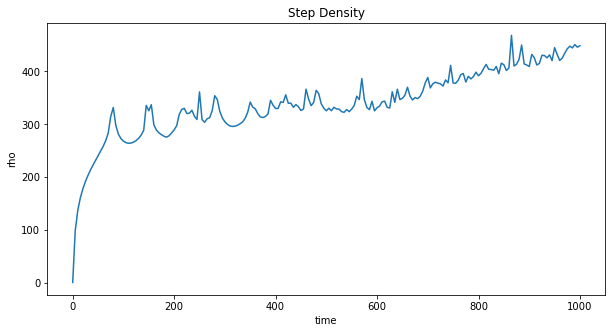

In [508]:
figure(figsize=(10,5))
plot(T, Rho[T])
title('Step Density')
xlabel('time'); ylabel('rho')
show()

#### Quantum Potential, Classical Potential and Kinetic Energy ####

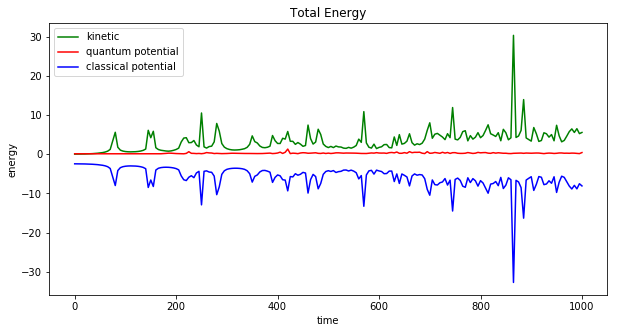

In [509]:
figure(figsize=(10,5))
plot(T, TK[T],color='green',label='kinetic')
plot(T, TQ[T],color='red',label='quantum potential')
plot(T, TP[T],color='blue',label='classical potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

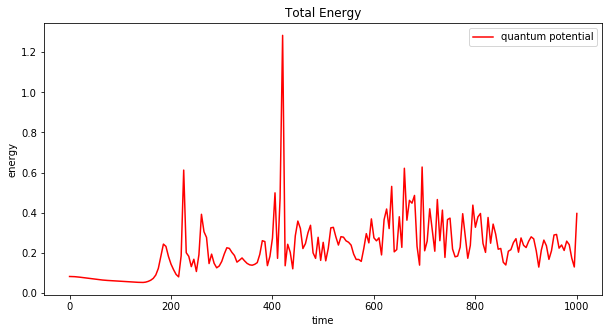

In [510]:
figure(figsize=(10,5))
plot(T, TQ[T],color='red',label='quantum potential')
legend()
title('Total Energy')
xlabel('time'); ylabel('energy')
show()

#### Energy Conservation ####

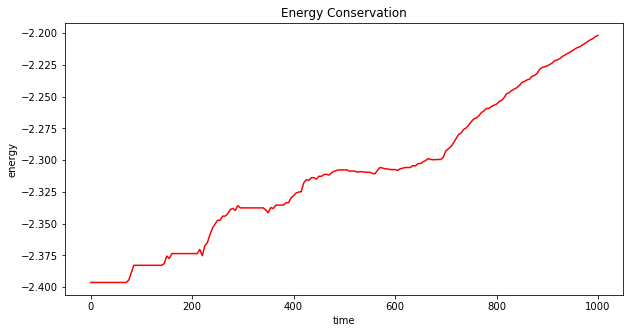

In [511]:
figure(figsize=(10,5))
plot(T, TK[T]+TP[T]+TQ[T],color='red')
title('Energy Conservation')
xlabel('time'); ylabel('energy')
show()

#### Trajectories ####
The trajectory of the particle in each world is shown below.  Notice how the trajectories do not cross, yet in some worlds the particle is scattered from the barrier while in others the particle tunnels across the barrier "pushed" by its counterpart in other worlds.

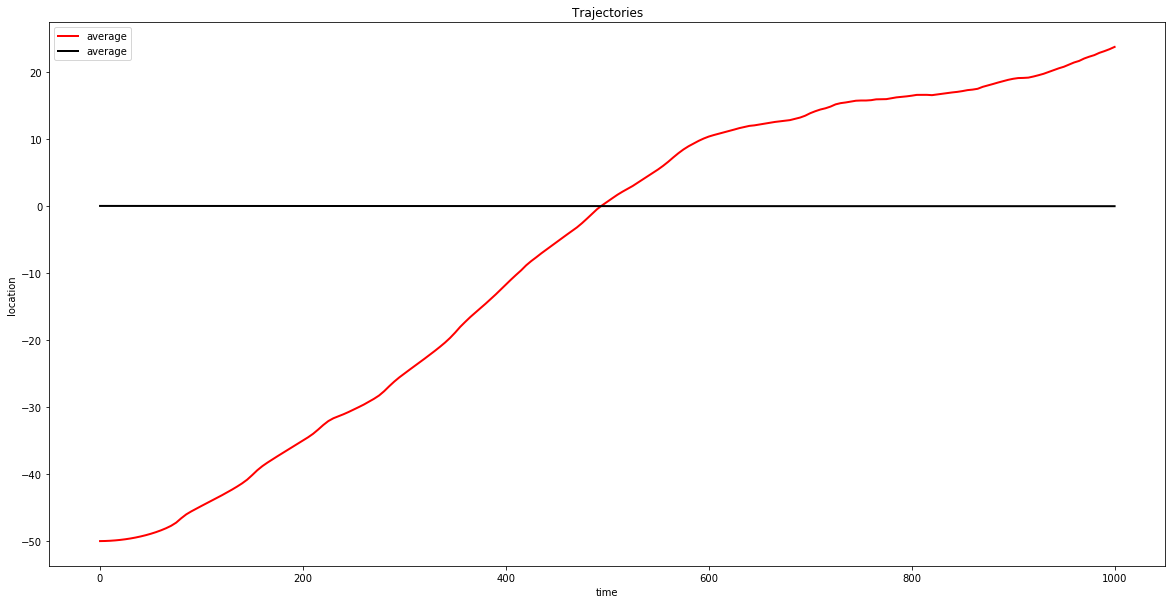

In [512]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='black',label='average',linewidth=2)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

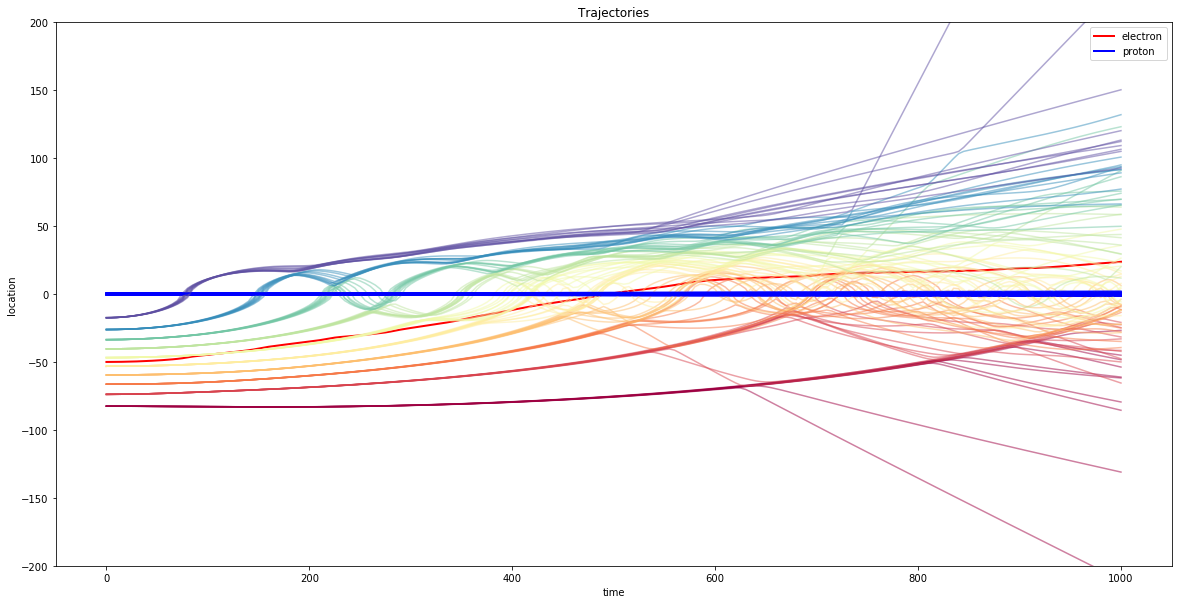

In [520]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='electron',linewidth=2)
plot(T, mean(XX[T][:,1],(1,2)), color='blue',label='proton',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(len(XS)):
    for j in range(len(XS)):
        plot(T, XX[T][:,0,i,j],color=line_color[i],alpha=0.5)
        plot(T, XX[T][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
#xlim(7750,8750)
ylim(-200,200)
show()

This picture reminds me of how cold anti-electrons and anti-protons must be in order to form anti-hydrogen.

Average velocity

In [514]:
mean(v.get_value()[0],(0,1))

In [515]:
from theano.tensor import min,max

In [516]:
min(v.get_value()[0],(0,1)).eval(),max(v.get_value()[0],(0,1)).eval()

(array(-1.067781332115535), array(1.4273829628350336))

#### Final Distribution ####
The distribution at the end of the simulation shows the reflected and transmitted "wave packets" separating from each other.

In greater detail ...

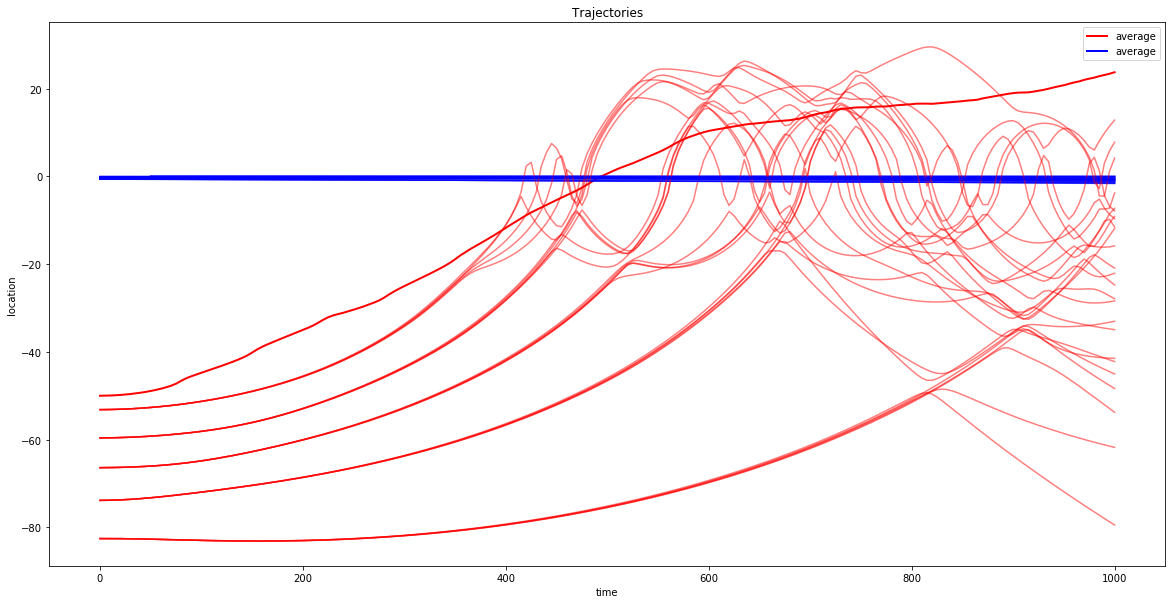

In [519]:
figure(figsize=(20,10))
plot(T, mean(XX[T][:,0],(1,2)), color='red',label='average',linewidth=2)
plot(T[10:], mean(XX[T[10:]][:,1],(1,2)), color='blue',label='average',linewidth=2)
line_color = Spectral(linspace(0,1,len(XS)))
for i in range(0,5): #range(len(XS)):
    for j in range(0,5): #range(len(XS)):
        plot(T, XX[T][:,0,i,j],color='red',alpha=0.5)
        plot(T, XX[T][:,1,i,j],color='blue',alpha=0.5)
legend()
title('Trajectories')
xlabel('time'); ylabel('location')
show()

In [522]:
def update_graph(t):
    return graph.set_offsets((XX[t][0],XX[t][1]))
fig = figure(figsize=(10,5))
ax = axes()
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
graph = ax.scatter([],[],s=0.5)
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
ani = animation.FuncAnimation(fig, update_graph, frames=T, interval=500)
close()
HTML(ani.to_html5_video())

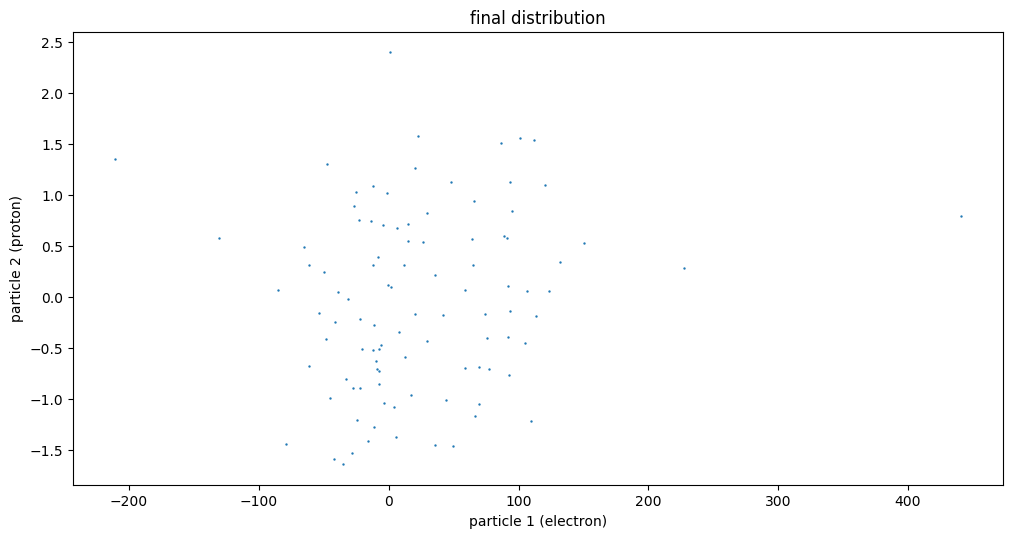

In [523]:
fig = figure(figsize=(12,6),dpi=100)
scatter(debound(x[0]).eval(),debound(x[1]).eval(),s=0.5)
title("final distribution")
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

In [524]:
from matplotlib.pyplot import hist

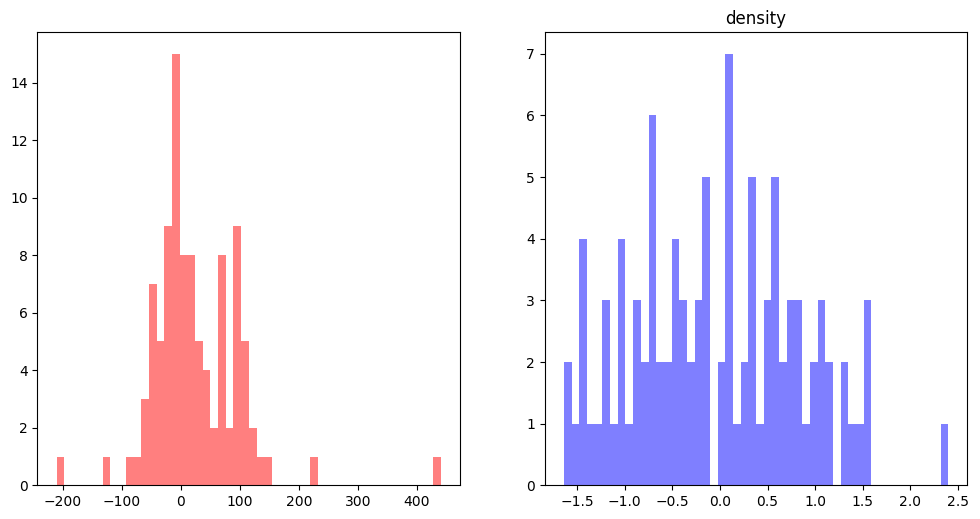

In [525]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(121)
ax1.hist(debound(x[0]).eval().flatten(),50,color='red',alpha=0.5)
ax1=fig.add_subplot(122)
ax1.hist(debound(x[1]).eval().flatten(),50,color='blue',alpha=0.5)
title('density')
show()

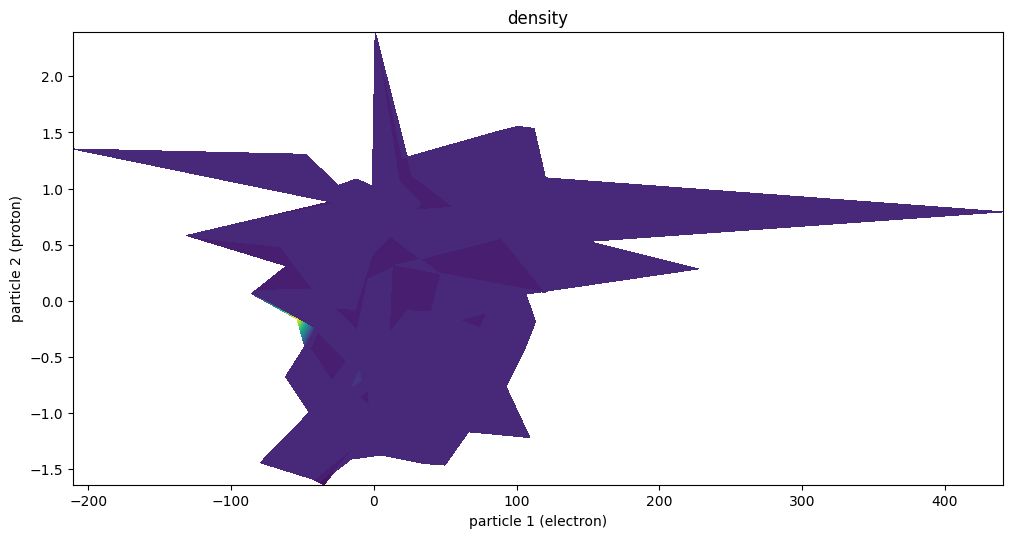

In [526]:
fig = figure(figsize=(12,6),dpi=100)
ax1=fig.add_subplot(111)
#ax1.set_aspect('equal')
ax1.contourf(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.eval()),30)
title('density')
xlabel('particle 1 (electron)'); ylabel('particle 2 (proton)')
show()

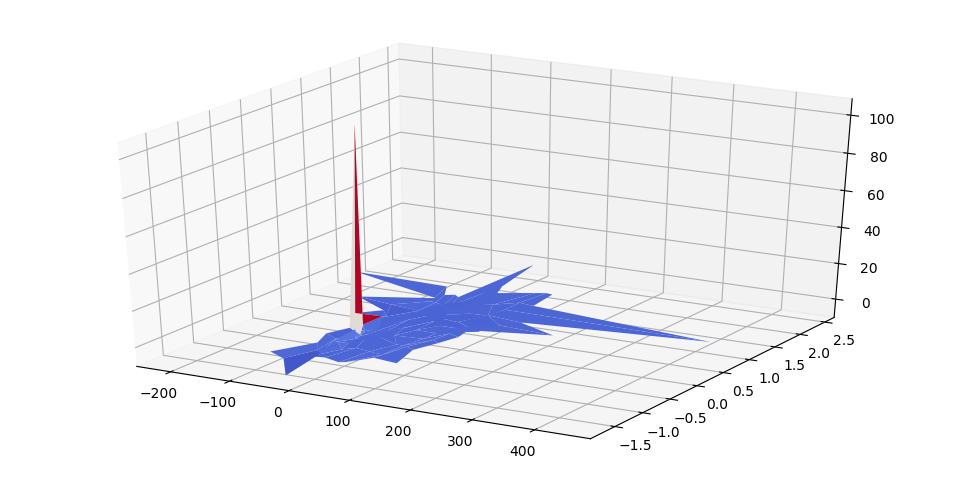

In [527]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(111, projection='3d')
# Plot the surface
ax1.plot_surface(debound(x[0]).eval(),debound(x[1]).eval(),D_(x.get_value()), cmap=coolwarm, linewidth=0, antialiased=True)
#ax1.view_init(50, 40)
show()

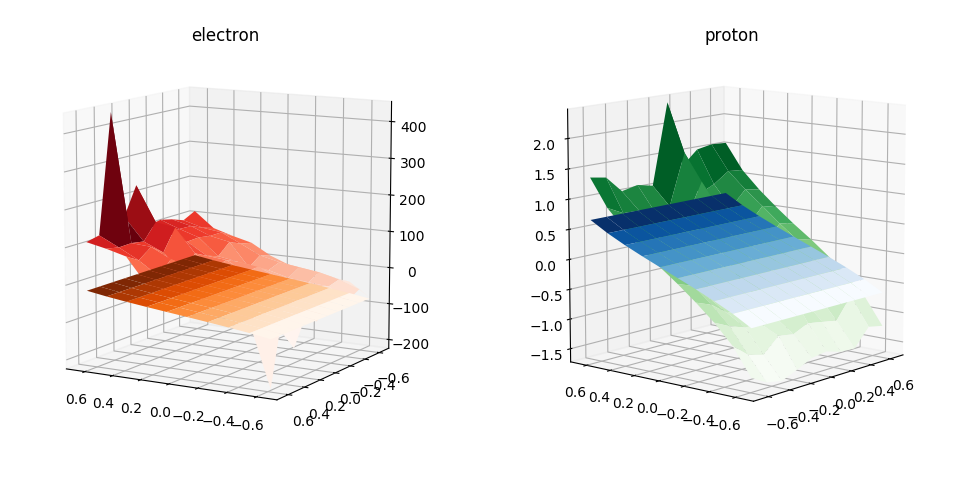

In [528]:
fig = figure(figsize=(12,6),dpi=100)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
# Plot the surface
p1=ax1.plot_surface(xy[0], xy[1], debound(x[0]).eval(), cmap=Reds, linewidth=0, antialiased=True, label='final')
p2=ax1.plot_surface(xy[0], xy[1], debound(b0[0]), cmap=Oranges, linewidth=0, antialiased=True, label='initial')
ax1.set_title('electron')
ax1.view_init(10, 120)
p3=ax2.plot_surface(xy[0], xy[1], debound(x[1]).eval(), cmap=Greens, linewidth=0, antialiased=True,label='final')
p4=ax2.plot_surface(xy[0], xy[1], debound(b0[1]), cmap=Blues, linewidth=0, antialiased=True, label='initial')
ax2.set_title('proton')
ax2.view_init(10, -140)
show()